# Bioimaging 2

## 1. Data

#### 1.1. Check working directory.

In [1]:
#Package
import os

#Command
os.getcwd()

'/home/howsetya/workspace/Bioimage2'

There are 4 directories of data, namely 2 sets of training and 2 sets of challenge datasets with the following relative path:
1. ./Images/training_BF-C2DL-HSC/01/subset/*.tif
2. ./Images/training_BF-C2DL-HSC/02/subset/*.tif
3. ./Images/challenge_BF-C2DL-HSC/01/subset/*.tif
4. ./Images/challenge_BF-C2DL-HSC/02/subset/*.tif

These are all subsets of the real complete dataset to save time in going through all the data. Each contains around 20% the amount of the complete data (0.2 * ~1700 = ~350 images).

Additionally, the training 01 dataset is further subset to get even fewer images in the path
./Images/training_BF-C2DL-HSC/01/subset2/*.tif

#### 1.2. Load Images

First, define a function to load image files and put them in a data frame.

In [2]:
#Imports
import glob, re
import pandas as pd
from skimage.io import imread, imshow, show

#Function
def load_imgs(path):
    files_img = glob.glob(path)
    files_img.sort()
    df_img = pd.DataFrame(columns=['FileName','Image'])
    for file in files_img:
        filename = re.sub(".*/", "", file[:-4])
        img = imread(file) #tifffile plugin for loading compressed tiffs requires imagecodecs
        df_img.loc[len(df_img)] = [filename,img]
        # print(file) #to show progress
        # imshow(img) #to show image
        # show()
    return(df_img)

In [94]:
#Set path
#This subset2 folder contains even fewer images than the one mentioned above 
path = ('./Images/training_BF-C2DL-HSC/01/subset2/*.tif')

#Load all images in the directory of the path
img_df = load_imgs(path)

#### 1.3. Inspection

In [4]:
#Check the data frame
img_df.shape
img_df.iloc[0:4]

,FileName,Image
0,t0001,"[[132, 132, 131, 133, 132, 131, 133, 134, 132,..."
1,t0040,"[[132, 132, 132, 132, 131, 133, 132, 134, 133,..."
2,t0080,"[[132, 132, 131, 132, 132, 130, 131, 133, 133,..."
3,t0100,"[[131, 133, 133, 131, 132, 131, 131, 131, 132,..."


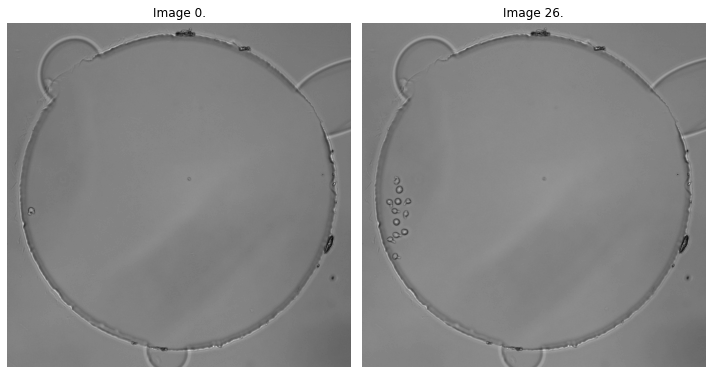

In [5]:
#Imports
import matplotlib.pyplot as plt

#Check the images
n1 = 0 # first image
n2 = 26 # last image
fig, ax = plt.subplots(1,2,figsize=(10,10))
[ax.set_axis_off() for ax in ax.ravel()]
ax[0].imshow(img_df.iloc[n1,1],cmap='gray')
ax[0].set_title(f'Image {n1}.')
ax[1].imshow(img_df.iloc[n2,1],cmap='gray')
ax[1].set_title(f'Image {n2}.')
fig.tight_layout()
plt.show()

## 2. Analysis

#### 2.1. Preliminary Observation

Just to get an idea of how the images of the other sets look like, one arbitrary image is taken from each directory and plotted.

In [6]:
#Load just one image from each directory.
tr1_ss = imread('./Images/training_BF-C2DL-HSC/01/subset/t1400.tif')
tr2_ss = imread('./Images/training_BF-C2DL-HSC/02/subset/t1400.tif')
ch1_ss = imread('./Images/challenge_BF-C2DL-HSC/01/subset/t1400.tif')
ch2_ss = imread('./Images/challenge_BF-C2DL-HSC/02/subset/t1400.tif')

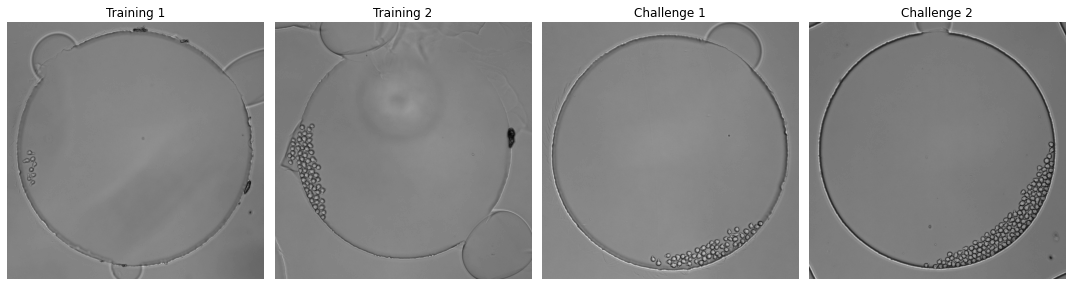

In [39]:
#Check the image
fig, ax = plt.subplots(1,4, figsize=(15,15))
[ax.set_axis_off() for ax in ax.ravel()]
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[1].imshow(tr2_ss,cmap='gray')
ax[1].set_title('Training 2')
ax[2].imshow(ch1_ss,cmap='gray')
ax[2].set_title('Challenge 1')
ax[3].imshow(ch2_ss,cmap='gray')
ax[3].set_title('Challenge 2')
fig.tight_layout()
plt.show()

As can be seen here, the wells seem to be nicely reasonably rounded except for one dataset (Training2). And glancing intuitively here, the images lack contrast, clearly demonstrated by the dominating grey colour over all the images from the background up to the cells themselves. The histogram also indicate the difficulty that would be encountered should a manual thresholding is to be done.

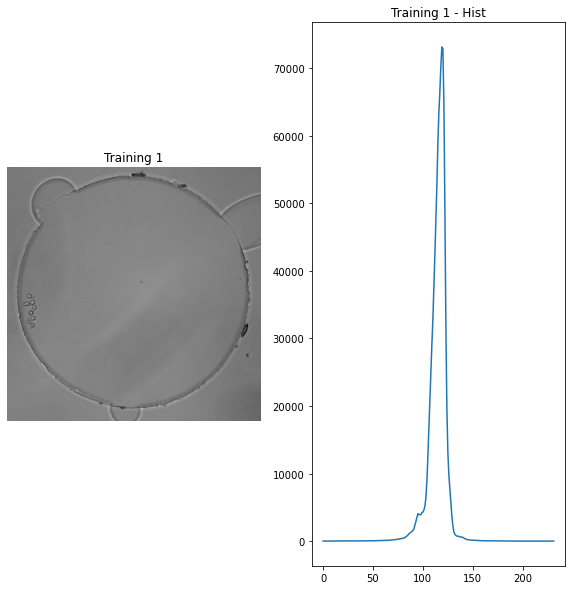

In [8]:
#Imports
from skimage import exposure

hist, hist_centers = exposure.histogram(tr1_ss)

#Plot
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[0].axis('off')
ax[1].plot(hist)
ax[1].set_title('Training 1 - Hist')
plt.show()

#### 2.2. Thresholding

Due to the observation above, efforts to improve contrast are therefore attempted by automatic thresholding using different methods available in skimage.

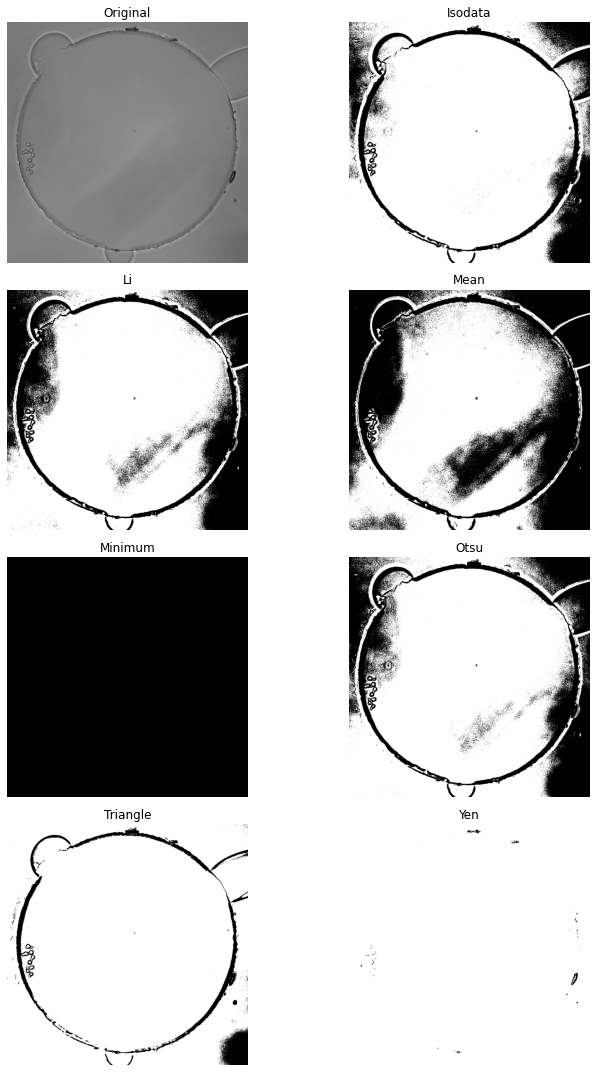

In [9]:
#Imports
from skimage.filters import try_all_threshold

#Plot
fig, ax = try_all_threshold(tr1_ss, figsize=(15, 15), verbose=False)
fig.tight_layout()
plt.show()

The Triangle thresholding method seems promising, at least for the one arbitrary example here.

This is then tried to the small subset that has been loaded before (Training 1 Subset 2). And the result seems fine enough, as seen below.

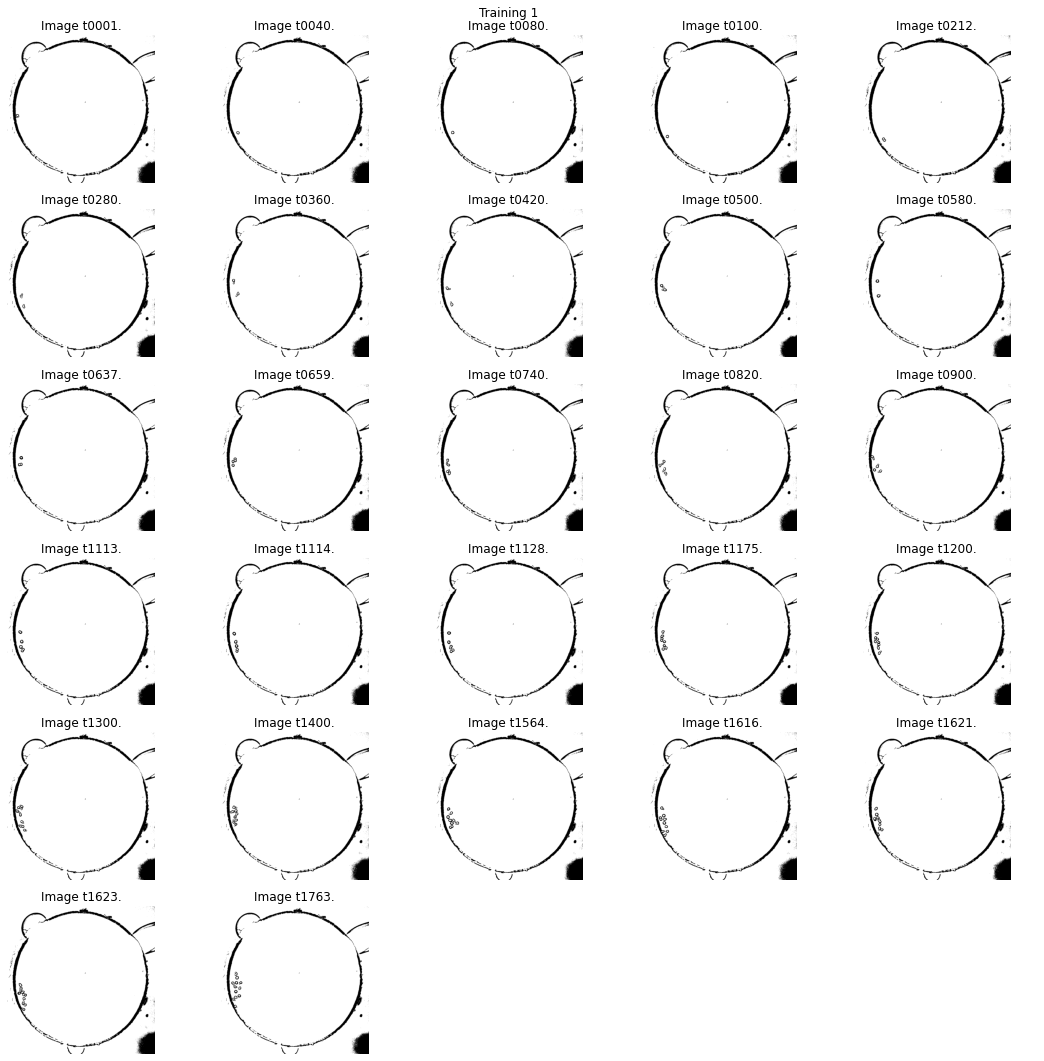

In [38]:
#Imports
from skimage.filters import threshold_triangle as tri

#Overview
fig, ax = plt.subplots(6,5,figsize=(15,15))
fig.suptitle('Training 1')
ax = ax.ravel()
for n in range(len(img_df)):
    thr = tri(img_df.iloc[n,1]) 
    binary_img = img_df.iloc[n,1] > thr
    title = img_df.iloc[n,0]
    ax[n].imshow(binary_img, cmap='gray')
    ax[n].set_title(f'Image {title}.')
[ax.set_axis_off() for ax in ax.ravel()]
fig.tight_layout()

    
#Alternatively, larger images
#for n in range(1,len(img_df),35):
#    thr = tri(img_df.iloc[n,1]) 
#    binary_img = img_df.iloc[n,1] > thr
#    title = img_df.iloc[n,0]
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    plt.title(f'Image {title}.')
#    show()

However, running it for other subset proves that the use of the triangle thresholding method seems to be problematic.

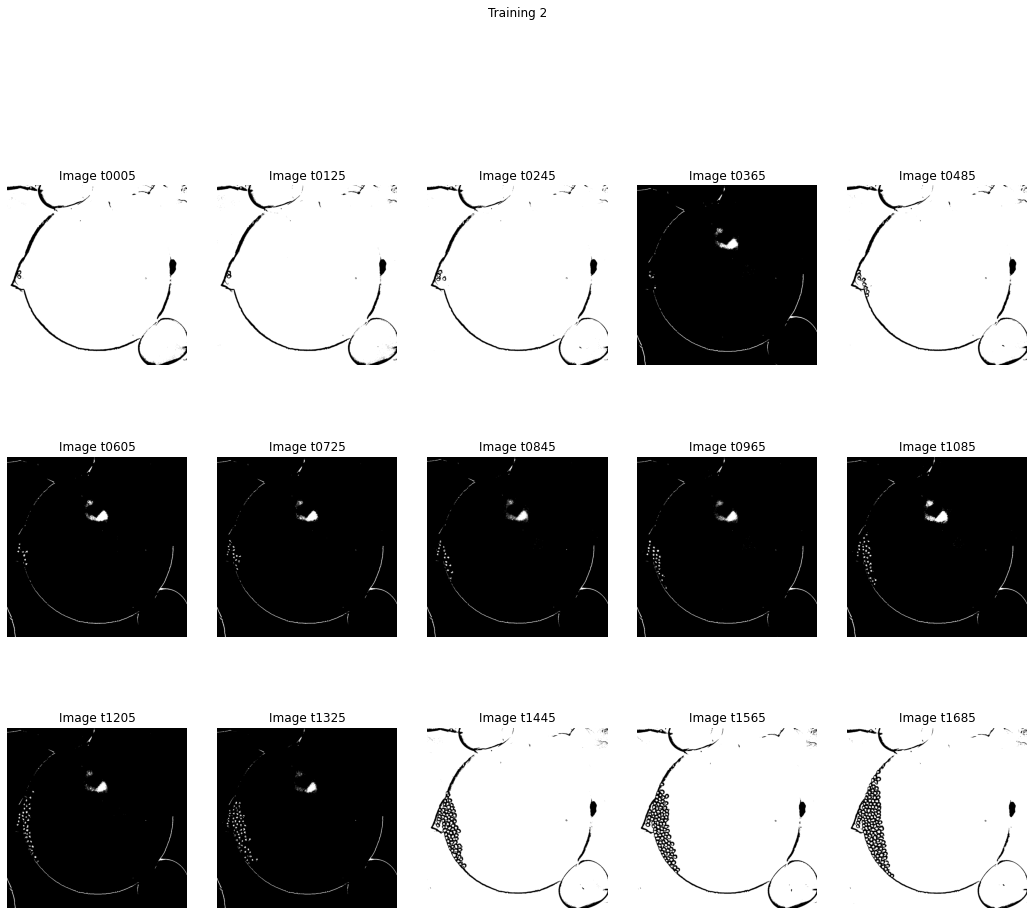

In [11]:
#Try other (sub)dataset, Training 2.
path2 = ('./Images/training_BF-C2DL-HSC/02/subset/*.tif')
img_df2 = load_imgs(path2)

#Overview
fig, ax = plt.subplots(3,5,figsize=(15,15))
fig.suptitle('Training 2')
ax = ax.ravel()
k=0
for n in range(1,len(img_df2),24): #Just sample some images
    thr = tri(img_df2.iloc[n,1]) 
    binary_img = img_df2.iloc[n,1] > thr
    title = img_df2.iloc[n,0]
    ax[k].imshow(binary_img, cmap='gray')
    ax[k].set_title(f'Image {title}')
    ax[k].axis('off')
    k=k+1
    fig.tight_layout(pad=3.0)
    
#Alternatively, larger images
#for n in range(1,len(img_df2),12):
#    thr = tri(img_df2.iloc[n,1]) 
#    binary_img = img_df2.iloc[n,1] > thr
#    title = img_df2.iloc[n,0]
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    plt.title(f'Image {title}.')
#    show()

The gray level pixel values of some images seem to be "flipped" after thresholding. This problem also persist through the other (sub)datasets. 

Inspecting the difference between the "flipped" image and "non-flipped" image seems that no major difference can be observed. However since the triangle method constructs a line between the histogram peak and the farthest end of the histogram [[1](https://www.kitware.com/histogram-based-thresholding/)][[2](http://www.mif.vu.lt/atpazinimas/dip/FIP/fip-Segmenta.html#Heading118)], it is probable that the line is constructed to the opposite ends of the histogram, depending on the image. On one image it may be directed toward 0, and oppositely on other image, depending on the longest distance to whichever end (zero or max).

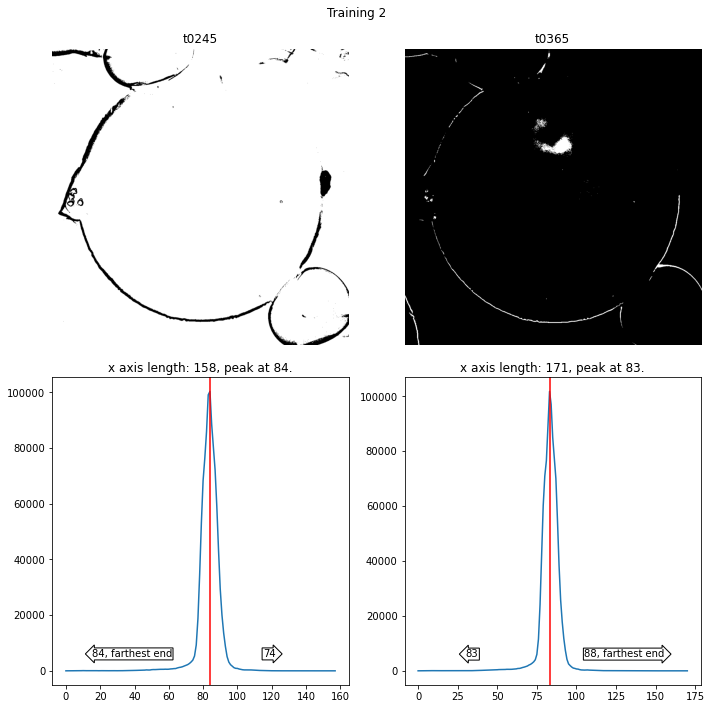

In [12]:
#Imports
import numpy as np

#Get Examples
flip = img_df2[img_df2["FileName"] == 't0245']
nflip = img_df2[img_df2["FileName"] == 't0365']
hist, hist_centers = exposure.histogram(flip.iloc[0,1])
nhist, nhist_centers = exposure.histogram(nflip.iloc[0,1])
flipbin = flip.iloc[0,1] > tri(flip.iloc[0,1])
nflipbin = nflip.iloc[0,1] > tri(nflip.iloc[0,1])

#Get peak position
flipm = np.argmax(hist)
nflipm = np.argmax(nhist)

#Detailed plots
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
fig.suptitle('Training 2')
ax[0].imshow(flipbin, cmap='gray')
ax[0].set_title(flip.iloc[0,0])
ax[0].axis('off')
ax[1].imshow(nflipbin, cmap='gray')
ax[1].set_title(nflip.iloc[0,0])
ax[1].axis('off')
ax[2].plot(hist)
ax[2].axvline(x=flipm, color='r')
ax[2].text(15, 5000, f'{flipm}, farthest end', bbox=dict(boxstyle='larrow,pad=0.1', fc='w', ec='k')) 
ax[2].text(115, 5000, f'{len(hist)-flipm}', bbox=dict(boxstyle='rarrow,pad=0.1', fc='w', ec='k')) 
ax[2].set_title(f'x axis length: {len(hist)}, peak at {flipm}.')
ax[3].plot(nhist)
ax[3].text(30, 5000, f'{nflipm}', bbox=dict(boxstyle="larrow,pad=0.1", fc="w", ec="k"))
ax[3].text(105, 5000, f'{len(nhist)-nflipm}, farthest end', bbox=dict(boxstyle='rarrow,pad=0.1', fc='w', ec='k'))
ax[3].axvline(x=nflipm, color='r')
ax[3].set_title(f'x axis length: {len(nhist)}, peak at {nflipm}.')
fig.tight_layout()
plt.show()

And indeed this is probably the case which makes the triangle thresholding method goes awry.

The code block below is an experiment to switch the making of the binary image according to which side the farthest end lies. However this does not work very well (commented to avoid running, uncomment to see result).

In [13]:
#Try again with if condition to switch. Does not work though

#Overview
#fig, ax = plt.subplots(6,5,figsize=(15,15))
#fig.suptitle('Training 2')
#ax = ax.ravel()
#k=0
#for n in range(1,len(img_df2),12): #Just sample some images
#    hist, hist_centers = exposure.histogram(img_df2.iloc[n,1])
#    peakpos = np.argmax(hist)
#    thr = tri(img_df2.iloc[n,1])
#    if (peakpos-(len(hist)-peakpos)) > -1 : #If peakpos>right side
#        binary_img = img_df2.iloc[n,1] > thr #Then normal
#    else : #If peakpos<right side
#        binary_img = img_df2.iloc[n,1] < thr #Then switch
#    title = img_df2.iloc[n,0]
#    ax[k].imshow(binary_img, cmap='gray')
#    ax[k].set_title(f'{title},A-B:{peakpos-(len(hist)-peakpos)},thr:{thr},pps:{peakpos}')
#    ax[k].axis('off')
#    k=k+1
#    fig.tight_layout()
    
#Alternatively, larger images
#for n in range(1,len(img_df2),12):
#    hist, hist_centers = exposure.histogram(img_df2.iloc[n,1])
#    peakpos = np.argmax(hist)
#    thr = tri(img_df2.iloc[n,1])
#    if (peakpos-(len(hist)-peakpos)) > -1 :
#        binary_img = img_df2.iloc[n,1] > thr
#    else :
#        binary_img = img_df2.iloc[n,1] < thr
#    title = img_df2.iloc[n,0]
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    plt.title(f'Image {title}.')
#    show()

Since I am not sure why it did not work well, another approach was taken. 

Checking the value of the triangle threshold, it seems like it works best if abs(threshold-histogram peak) < ~10, just by observation. So now trying that hypothesis.

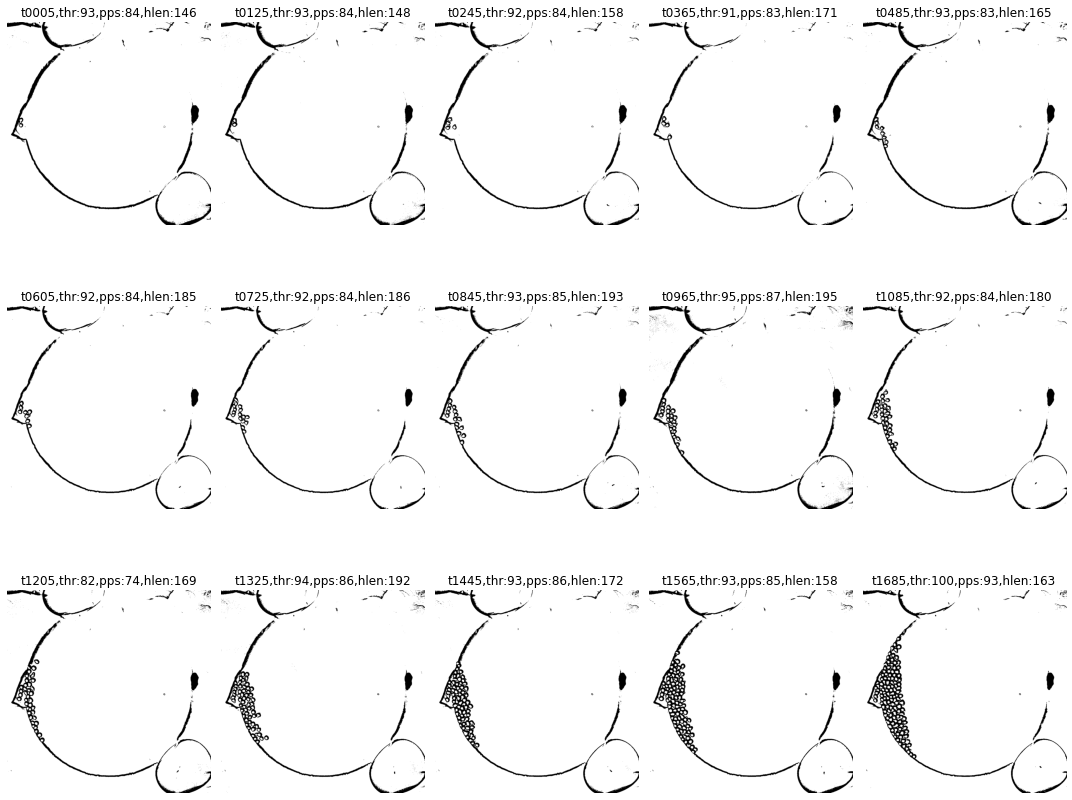

In [14]:
#Try again with manual adjustment of differences between threshold and peak position.

#Overview
fig, ax = plt.subplots(3,5,figsize=(15,15))
ax = ax.ravel()
k=0
for n in range(1,len(img_df2),24): #Just sample some images
    hist, hist_centers = exposure.histogram(img_df2.iloc[n,1])
    peakpos = np.argmax(hist)
    thr = tri(img_df2.iloc[n,1])
    if (abs(peakpos-thr)) <= 10 : #If the difference is less than 10 (manual observation)
        binary_img = img_df2.iloc[n,1] > thr #Then normal
    else : #Otherwise
        thr = peakpos + 8 #Set thr to be peakpos + 8 (arbitrary)
        binary_img = img_df2.iloc[n,1] > thr 
    title = img_df2.iloc[n,0]
    ax[k].imshow(binary_img, cmap='gray')
    ax[k].set_title(f'{title},thr:{thr},pps:{peakpos},hlen:{len(hist)}')
    ax[k].axis('off')
    k=k+1
    fig.tight_layout()

The result seems better than expected. But at this point, might as well just abandon the triangle thresholding method and try manual thresholding for all images by setting the threshold in respect/relative to the histogram peak position.

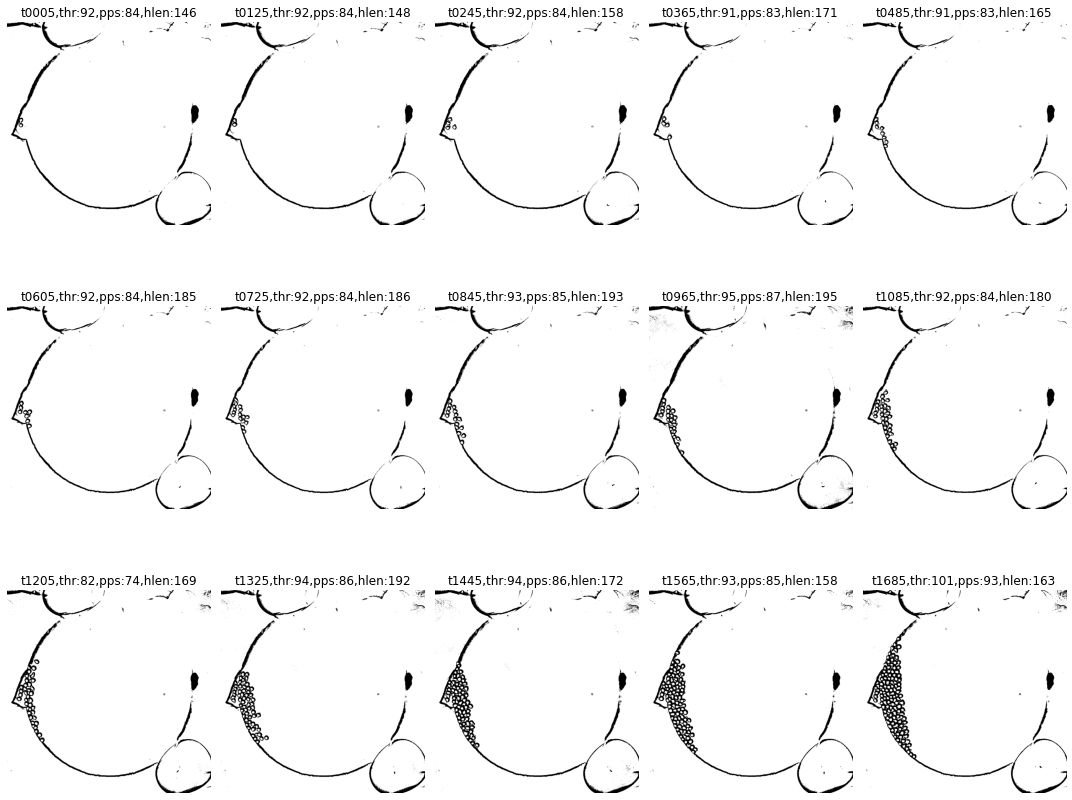

In [15]:
#Thresholding relative to histogram peak position
fig, ax = plt.subplots(3,5,figsize=(15,15))
#fig.suptitle('Training 2')
ax = ax.ravel()
k=0
for n in range(1,len(img_df2),24): #Just sample some images
    hist, hist_centers = exposure.histogram(img_df2.iloc[n,1])
    peakpos = np.argmax(hist)
    thr = peakpos + 8 #Threshold 8 values away from peakpos
    binary_img = img_df2.iloc[n,1] > thr 
    title = img_df2.iloc[n,0]
    ax[k].imshow(binary_img, cmap='gray')
    ax[k].set_title(f'{title},thr:{thr},pps:{peakpos},hlen:{len(hist)}')
    ax[k].axis('off')
    k=k+1
    fig.tight_layout()

Surprisingly, that seems to work well enough and quite similar to the result of triangle thresholding method when it does work. 

Well, there goes a week's worth of experimenting down the drain, just to go use manual thresholding in the end. Not sure if I am going to include here my experiment with Sobel and Canny edge detections. That's an entirely different wormhole.

Now proceed to check with other (sub)datasets (commented to avoid running, uncomment to see result).

In [16]:
#Now check other (sub)dataset, looks ok.
#Challenge 1.
path3 = ('./Images/challenge_BF-C2DL-HSC/01/subset/*.tif')
img_df3 = load_imgs(path3)

#fig, ax = plt.subplots(3,5,figsize=(15,15))
#fig.suptitle('Challenge 1')
#ax = ax.ravel()
#k=0
#for n in range(1,len(img_df3),24): #Just sample some images
#    hist, hist_centers = exposure.histogram(img_df3.iloc[n,1])
#    peakpos = np.argmax(hist)
#    thr = peakpos + 8
#    binary_img = img_df3.iloc[n,1] > thr 
#    title = img_df3.iloc[n,0]
#    ax[k].imshow(binary_img, cmap='gray')
#    ax[k].set_title(f'{title},thr:{thr},pps:{peakpos},hlen:{len(hist)}')
#    ax[k].axis('off')
#    k=k+1
#    fig.tight_layout()

In [17]:
#Challenge 2, another one, also looks ok.
path4 = ('./Images/challenge_BF-C2DL-HSC/02/subset/*.tif')
img_df4 = load_imgs(path4)

#fig, ax = plt.subplots(3,5,figsize=(15,15))
#fig.suptitle('Challenge 2')
#ax = ax.ravel()
#k=0
#for n in range(1,len(img_df4),24): #Just sample some images
#    hist, hist_centers = exposure.histogram(img_df4.iloc[n,1])
#    peakpos = np.argmax(hist)
#    thr = peakpos + 8
#    binary_img = img_df4.iloc[n,1] > thr 
#    title = img_df4.iloc[n,0]
#    ax[k].imshow(binary_img, cmap='gray')
#    ax[k].set_title(f'{title},thr:{thr},pps:{peakpos},hlen:{len(hist)}')
#    ax[k].axis('off')
#    k=k+1
#    fig.tight_layout()

In [18]:
#Make thresholding function
def thresh(image_arr):
    hist, hist_centers = exposure.histogram(image_arr)
    peakpos = np.argmax(hist)
    thr = peakpos + 8
    binary_img = image_arr > thr 
    return(binary_img)

Apply threshold and put the result in a new column in the parent dataframe.

In [95]:
#Put binary image in the dataframe in a new column
img_df['Binary']= ''
for n in range(0,len(img_df),1):
    image_arr = img_df.iloc[n,1]
    binary_img = thresh(image_arr) 
    img_df.iloc[n,2] = np.array([binary_img])
#Check
img_df.iloc[0:4]

,FileName,Image,Binary
0,t0001,"[[132, 132, 131, 133, 132, 131, 133, 134, 132,...","[[[True, True, True, True, True, True, True, T..."
1,t0040,"[[132, 132, 132, 132, 131, 133, 132, 134, 133,...","[[[True, True, True, True, True, True, True, T..."
2,t0080,"[[132, 132, 131, 132, 132, 130, 131, 133, 133,...","[[[True, True, True, True, True, True, True, T..."
3,t0100,"[[131, 133, 133, 131, 132, 131, 131, 131, 132,...","[[[True, True, True, True, True, True, True, T..."


#### 2.3. Masking

It seems though now it may be neccessary to mask the outer part of the well to exclude potential problems.

To this end, a mask is made for the well in each dataset. All the wells looks well rounded and only ever so slightly off-center. So a simple circle masking could probably work for all dataset except for the Training 2 dataset. Nevertheless, a bespoke masking option might as well be available for other datasets.

(In the end this seemed like a good idea to exclude unnecessary parts as much as possible)

In [62]:
#Imports
from skimage import draw

# Masking function
def mask_set(image_arr,set=''):
    image_arr = np.squeeze(image_arr)#not sure why squeeze is necessary
    image_arr_copy = np.squeeze(image_arr)
    mask = np.ones(shape=image_arr.shape, dtype="bool")
    if set == 'tr1': #for training 1 dataset
        #rr, cc = draw.rectangle(start=(250, 400), extent=(300, 200))
        #mask[rr, cc] = True
        rr, cc = draw.disk((514, 458), 401) #((y,x),rad)
        mask[rr, cc] = False
    elif set == 'tr2': #for training 2 dataset
        #rr, cc = draw.polygon((560,328,766),(25,117,178))
        rr, cc = draw.ellipse(455,175,80,170,rotation=np.deg2rad(45)) #better than polygon
        mask[rr, cc] = False
        rr1, cc1 = draw.disk((512, 488), 405)
        mask[rr1,cc1] =False
    elif set == 'ch1': #for challenge 1 dataset
        rr, cc = draw.disk((520, 505), 450)
        mask[rr, cc] = False
    elif set == 'ch2': #for challenge 2 dataset
        rr, cc = draw.disk((515, 515), 451)
        mask[rr, cc] = False
    else:
        print('Specify set (tr1, tr2, ch1, or ch2).')
    image_arr_copy[mask] = 1
    return(image_arr_copy)
    #return(np.squeeze(mask))

In [97]:
#Put masked image in the parent dataframe
img_df['Masked']=''
for n in range(0,len(img_df),1):
    masked = mask_set(img_df.iloc[n,2],set='tr1')
    img_df.iloc[n,3] = np.array([masked])
    #fig, ax = plt.subplots(figsize=(8,8))
    #ax.imshow(img_df.iloc[n,3])

In [26]:
#Check dataframe
img_df.iloc[0:4]

,FileName,Image,Binary,Masked
0,t0001,"[[132, 132, 131, 133, 132, 131, 133, 134, 132,...","[[[True, True, True, True, True, True, True, T...","[[[True, True, True, True, True, True, True, T..."
1,t0040,"[[132, 132, 132, 132, 131, 133, 132, 134, 133,...","[[[True, True, True, True, True, True, True, T...","[[[True, True, True, True, True, True, True, T..."
2,t0080,"[[132, 132, 131, 132, 132, 130, 131, 133, 133,...","[[[True, True, True, True, True, True, True, T...","[[[True, True, True, True, True, True, True, T..."
3,t0100,"[[131, 133, 133, 131, 132, 131, 131, 131, 132,...","[[[True, True, True, True, True, True, True, T...","[[[True, True, True, True, True, True, True, T..."


Apply masking and put the result in a new column in the parent dataframe.

#### 2.4. Comparing with Edge detection (and local thresholding)

However the result of thresholding leaves line(s) of the well that is difficult to remove which may interfere, no matter how much I played with the masking, and also the cells themselves looks a little weird. Trying canny as comparison. And while I'm at it, since I forgot about local thresholding, so here comparing with it too.

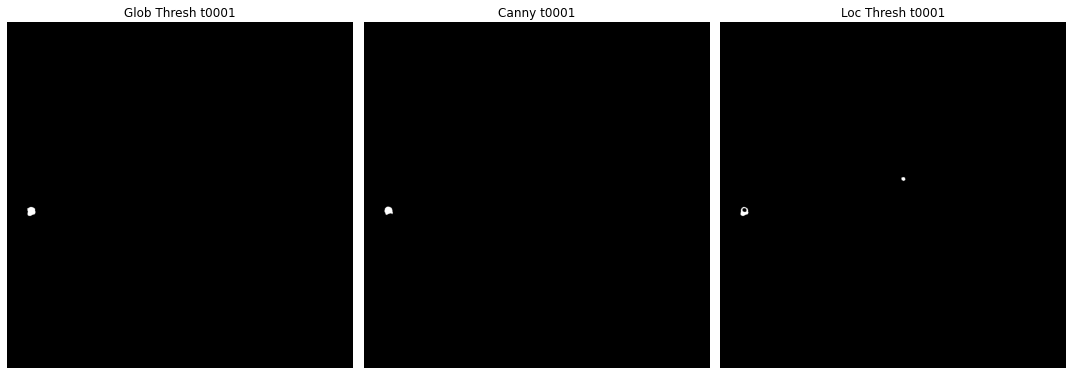

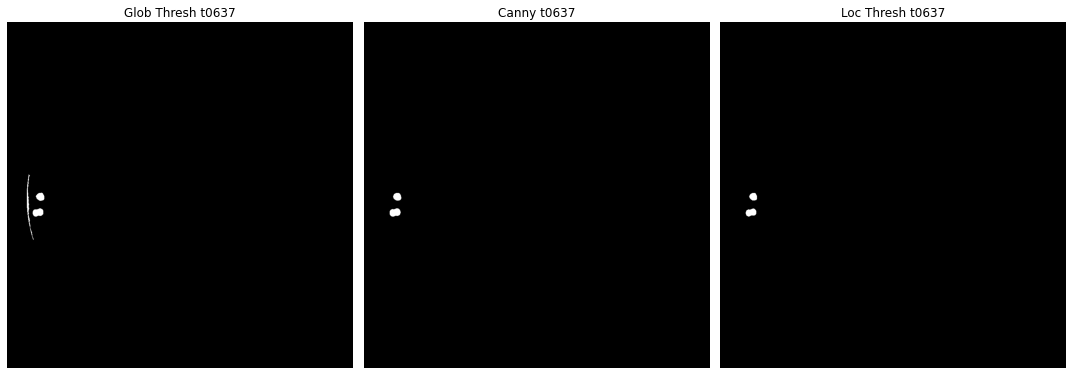

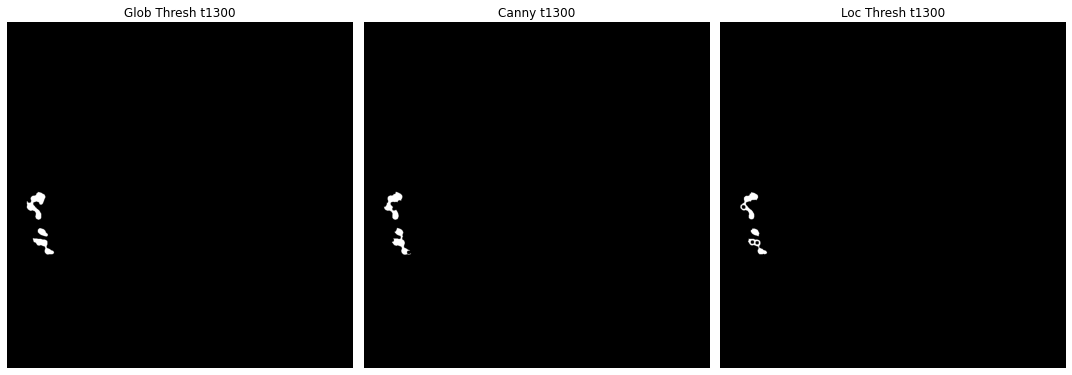

In [102]:
#Imports
from skimage import util
from skimage.morphology import remove_small_objects
import scipy.ndimage as ndi
from skimage.feature import canny
from skimage.morphology import binary_dilation,binary_erosion, disk, square

from skimage.filters import threshold_local 
block_size = 35

#Closing operation but with different structuring element
d_struct = disk(5)
e_struct = disk(5)

comparison = img_df #Change (sub)dataset as needed
sset='tr1' 
for n in range(0,len(comparison),10): #Change this as well according to dataset
    
    #global threshold
    binary_img = comparison.iloc[n,2] #Binary image column
    tmasked = mask_set(binary_img,set=sset) #Change set accordingly 
    tinv = util.invert(tmasked) #Invert values so bg is 0
    tcleaned = remove_small_objects(tinv) #Cleaning
    tdilated = binary_dilation(tcleaned,d_struct)
    teroded = binary_erosion(tdilated,e_struct)
    #filledt = ndi.morphology.binary_fill_holes(tinv)
    
    #canny
    edge = canny(comparison.iloc[n,1],sigma=2) 
    cinv = util.invert(edge) #Invert to fit with mask
    cmasked = mask_set(cinv,set=sset) 
    cinv2 = util.invert(cmasked) #Invert again to get bg as black
    cdilated = binary_dilation(cinv2,d_struct)
    ceroded = binary_erosion(cdilated,e_struct)
    #filledc = ndi.morphology.binary_fill_holes(cinv2)
    
    #local threshold
    image = comparison.iloc[n,1]
    loc_t= threshold_local(image, block_size, offset=10)
    lbin = image > local_thresh
    lmasked = mask_set(lbin,set=sset)
    linv = util.invert(lmasked) #Invert values so bg is 0
    lcleaned = remove_small_objects(linv) #Cleaning
    ldilated = binary_dilation(lcleaned,d_struct)
    leroded = binary_erosion(ldilated,e_struct)
    #filledl = ndi.morphology.binary_fill_holes(cinv2)
    
    #plot
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(teroded,cmap='gray')
    ax[0].set_title(f'Glob Thresh {comparison.iloc[n,0]}')
    ax[1].imshow(ceroded,cmap='gray')
    ax[1].set_title(f'Canny {comparison.iloc[n,0]}')
    ax[2].imshow(leroded,cmap='gray')
    ax[2].set_title(f'Loc Thresh {comparison.iloc[n,0]}')
    [ax.set_axis_off() for ax in ax.ravel()]
    fig.tight_layout()
    show()
    

In fact, at least for this subset, either using canny edge detection or thresholding does not give much difference. Even the unmasked well outline can be removed depending on the size of dilation-erosion process (closing). 

However along the experiment, trying other subsets, it seems evident that the global thresholding does not perform well for other subsets, the local thresholding as well (e.g.: img_df3, ch1 subset).

#### 2.5. Watershed

Watershedding with cv2, seems easier to understand than skimage.

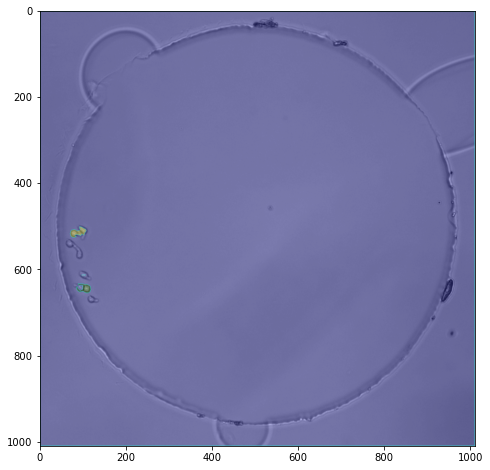

In [188]:
#Imports
import cv2

img_test = img_df.iloc[20,1]
val=0.9

#Find definite background by dilating the cells 
edge = canny(img_test,sigma=2) 
cinv = util.invert(edge) #Invert to fit with mask
cmasked = mask_set(cinv,set='tr1') 
cinv2 = util.invert(cmasked) #Invert again to get bg as black
cdilated = binary_dilation(cinv2,disk(4))
def_bg = np.uint8(cdilated.astype(int)*255) #Convert from boolean to int8
#####plt.imshow(def_bg) #Black is definitely background

#Find definite cell centers
#Calculates the distance to the closest zero pixel for each pixel of the source image. 
dist_transform = cv2.distanceTransform(def_bg,cv2.DIST_L2,5) #DIST_L2 is euclidian distance
#plt.imshow(dist_transform, cmap='gray') #Dist transformed img. 
#print(dist_transform.max()) #This is the max distance
ret2, def_cen = cv2.threshold(dist_transform,val*dist_transform.max(),255,0) #threshold dist by val*max 
#####plt.imshow(def_cen, cmap='gray')

#Ambiguous region is bg-centers
def_cen = np.uint8(def_cen)  #Convert from float to int8
unknown = cv2.subtract(def_bg,def_cen)
#####plt.imshow(unknown, cmap='gray')

#Create a marker and label the regions inside. 
#Both foreground and background will be labeled with positive, unknown will be labeled 0. 
#Use ConnectedComponents for markers
ret3, markers = cv2.connectedComponents(def_cen)
#####plt.imshow(markers,cmap='jet')

#Add a number to all labels so that definite background is not 0
markers = markers+10

#Mark the region of unknown with zero
markers[unknown==255] = 0
#####plt.imshow(markers, cmap='jet') #Look at the 3 distinct regions.

#Watershed filling. 
ori_img = cv2.cvtColor(img_test, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(ori_img,markers)

#Color boundaries in yellow. 
#Remember that watershed assigns boundaries a value of -1
ori_img[markers == -1] = [0,255,255]  

#label2rgb - Return an RGB image where color-coded labels are painted over the image.
from skimage import measure, color, io
img2 = color.label2rgb(markers, bg_label=0)
#####plt.imshow(img2)

#plot
#fig, ax = plt.subplots(2,3,figsize=(15,15))
#ax = ax.ravel()
#ax[0].imshow(def_bg,cmap='gray')
#ax[0].set_title(f'Def BG {img_df.iloc[20,0]}')
#ax[1].imshow(def_cen,cmap='gray')
#ax[1].set_title(f'Def FG')
#ax[2].imshow(unknown,cmap='gray')
#ax[2].set_title(f'Unknown')
#ax[3].imshow(markers,cmap='gist_rainbow')
#ax[3].set_title(f'Markers')
#ax[4].imshow(img2,cmap='gist_rainbow')
#ax[4].set_title(f'Labeled')
#ax[5].imshow(ori_img,cmap='gray')
#ax[5].imshow(img2,alpha=0.2)
#ax[5].set_title(f'Ori Img')
#fig.tight_layout()
#[ax.set_axis_off() for ax in ax.ravel()]
#show()

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(ori_img,cmap='gray')
ax.imshow(img2,alpha=0.2,cmap='gist_rainbow')
#ax.set_title(c_countl.max())

Trying with skimage anyway. This time see if I can get good result?

Text(0.5, 1.0, '5')

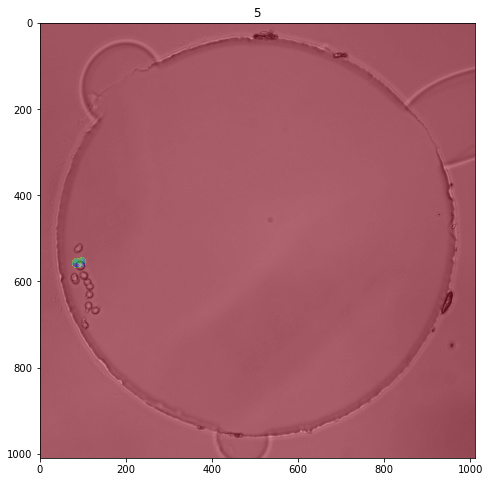

In [190]:
#Imports
import scipy.ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure

img_test = img_df.iloc[24,1]
cstruct = disk(5)
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

edge = canny(img_test,sigma=2) 
cinv = util.invert(edge) #Invert to fit with mask
cmasked = mask_set(cinv,set='tr1') 
cinv2 = util.invert(cmasked) #Invert again to get bg as black
cdilated = binary_dilation(cinv2,disk(4))
#filled = ndi.morphology.binary_fill_holes(cinv2)
distance = ndi.distance_transform_edt(cdilated)
coords = peak_local_max(distance, footprint=cstruct, labels=cdilated)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask,structure=s)
labeled = watershed(-distance, markers, mask=filled, compactness=0)
c_countl = measure.label(labeled)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(img_test,cmap='gray')
ax.imshow(labeled,cmap='gist_rainbow',alpha=0.3)
ax.set_title(c_countl.max())
#ax[0].imshow(-distance, cmap='gray')
#ax.imshow(inv2,cmap='gray')
#ax.set_title(img_df.iloc[n,0])
#ax.imshow(labeled,cmap='gist_rainbow',alpha=0.3)
#ax.set_title(c_countl.max())
#fig.tight_layout()
#show()

In [176]:
plt.imshow(cinv2)

[[1, 1, 1], [1, 1, 1], [1, 1, 1]]
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [ ]:
#Pusiiiiiiing

from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage import util 
import scipy.ndimage as ndi
from skimage.morphology import binary_dilation, binary_erosion, disk, square
#struct = square(3)
dstruct = disk(5)
estruct = disk(9)
cstruct = disk(7)
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure

#for n in range(0,len(img_df),1):
#    edge = canny(img_df.iloc[n,1],sigma=2) 
#    inv = util.invert(edge)
#    masked = mask_set(inv,set='tr1') #Change set accordingly 
#    inv2 = util.invert(masked)
    #dilated = binary_dilation(masked,selem=dstruct)
    #eroded = binary_erosion(dilated,selem=estruct)
    #filled = ndi.morphology.binary_fill_holes(eroded)
    #distance = ndi.distance_transform_edt(filled)
    #coords = peak_local_max(distance, footprint=cstruct, labels=filled)
    #mask = np.zeros(distance.shape, dtype=bool)
    #mask[tuple(coords.T)] = True
    #markers, _ = ndi.label(mask,structure=s)
    #labeled = watershed(-distance, markers, mask=filled, compactness=0)
    #c_count = measure.label(filled)
    #c_countl = measure.label(labeled)
    #fig, ax = plt.subplots(1,1,figsize=(8,8))
    #ax[0].imshow(filled,cmap='gray')
    #ax[0].set_title(c_count.max())
    #ax[0].imshow(-distance, cmap='gray')
    #ax.imshow(inv2,cmap='gray')
    #ax.set_title(img_df.iloc[n,0])
    #ax.imshow(labeled,cmap='gist_rainbow',alpha=0.3)
    #ax.set_title(c_countl.max())
    #fig.tight_layout()
    #show()

In [ ]:
#from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.measure import label
from skimage import util 

#inverted_img = util.invert(img)

for n in range(0,len(img_df),1):
    #binary_img = img_df.iloc[n,2] #Binary image column
    #masked = mask_set(binary_img,set='tr1') #Change set accordingly 
    inv = util.invert(masked)
    lab = label(masked,background=0) #specifiy which value to assign to background
    overlay = label2rgb(lab, bg_label=0)
    #fig, ax = plt.subplots(1,3,figsize=(15,15))
    #ax[0].imshow(inv,cmap='gray')
    #ax[1].imshow(lab)
    #ax[2].imshow(overlay)
    #ax[0].set_title(img_df.iloc[n,0])
    #show()

In [ ]:
overlay.shape